#### Librairies

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import unicodedata
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.stats import loguniform
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


C:\Users\Catello\.conda\envs\NLP2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Data Import

In [2]:
data = load_dataset("tweets-hate-speech-detection/tweets_hate_speech_detection")

In [3]:
# Access the train split and view the column names and a few rows
train_data = data['train']
print(train_data.column_names)

['label', 'tweet']


In [4]:
# Check the type of train_data
print(type(train_data))

<class 'datasets.arrow_dataset.Dataset'>


In [5]:
# Access the train split
train_data = data['train']

# Convert the dataset to a Pandas DataFrame and assign it to 'df'
df = pd.DataFrame(train_data)

df

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to w...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


#### Data Visualisation

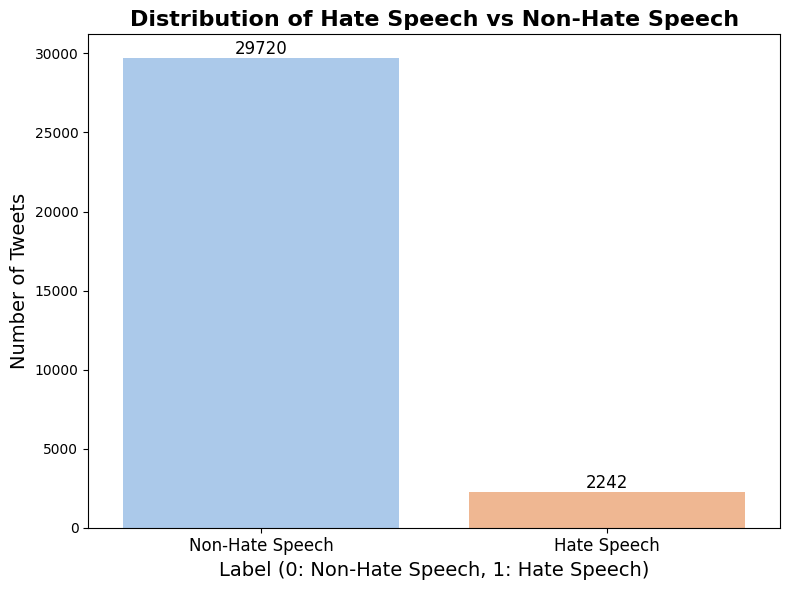

In [6]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Create a bar plot to visualize the distribution
plt.figure(figsize=(8, 6))
# Use a soft pastel color palette
sns.barplot(x=label_counts.index, y=label_counts.values, palette='pastel')

# Title and labels
plt.title('Distribution of Hate Speech vs Non-Hate Speech', fontsize=16, fontweight='bold')
plt.xlabel('Label (0: Non-Hate Speech, 1: Hate Speech)', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)

# Customize x-ticks
plt.xticks(ticks=[0, 1], labels=['Non-Hate Speech', 'Hate Speech'], fontsize=12)

# Add data labels on top of the bars
for index, value in enumerate(label_counts.values):
    plt.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


#### Data Analysis

In [7]:
# Calculate the length of each tweet
df['tweet_length'] = df['tweet'].apply(len)

# Calculate the average tweet length
average_length = df['tweet_length'].mean()
print(f'Average Length of Tweets: {average_length:.2f} characters')


Average Length of Tweets: 84.56 characters


In [8]:
# Tokeniser les tweets et compter les mots
word_list = []
for tweet in df['tweet']:
    words = nltk.word_tokenize(tweet)
    word_list.extend(words)

word_freq = Counter(word_list)
most_common_words = word_freq.most_common(10)
print(f'Most Common Words: {most_common_words}')

# Fonction pour extraire les hashtags d'un tweet
def extract_hashtags(tweet):
    hashtags = re.findall(r'#\w+', tweet)
    return hashtags

# Extraire les hashtags de tous les tweets
all_hashtags = []
for tweet in df['tweet']:
    all_hashtags.extend(extract_hashtags(tweet))

# Compter les hashtags
hashtag_freq = Counter(all_hashtags)
most_common_hashtags = hashtag_freq.most_common(10)
print(f'Most Common Hashtags: {most_common_hashtags}')

Most Common Words: [('#', 76675), ('@', 18212), ('user', 17577), ('!', 14650), ('.', 12133), ('the', 10147), ('to', 9833), ('i', 7161), ('a', 6449), (',', 6305)]
Most Common Hashtags: [('#love', 1542), ('#positive', 874), ('#healthy', 571), ('#smile', 548), ('#thankful', 491), ('#fun', 434), ('#life', 406), ('#summer', 367), ('#model', 365), ('#affirmation', 363)]


#### Data Cleaning

#### Handle Diacritics using text normalization

In [9]:
def simplify(text):
    '''Function to handle the diacritics in the text.'''
    return unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")

df['tweet'] = df['tweet'].apply(simplify)  # Assuming 'tweet' is the column name
print("After Simplifying Text:")
df.head()

After Simplifying Text:


,label,tweet,tweet_length
0,0,@user when a father is dysfunctional and is so...,101
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,19
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,38


#### Remove user handles

In [10]:
def extract_handles(text):
    '''Function to extract user handles from the text.'''
    pattern = re.compile(r'@\w+')  # Regular expression to match @usernames
    return re.findall(pattern, text)  # Return the list of found user handles

# Remove user handles from the original 'tweet' column
df['tweet'].replace(r'@\w+', '', regex=True, inplace=True)

# Display the result after both steps
print("After Extracting and Removing User Handles:")
df.head()

After Extracting and Removing User Handles:


,label,tweet,tweet_length
0,0,when a father is dysfunctional and is so self...,101
1,0,thanks for #lyft credit i can't use cause th...,122
2,0,bihday your majesty,19
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,38


#### Remove the urls

In [11]:
# Remove URLs from the 'tweet' column in the DataFrame
df['tweet'].replace(r'http\S+', '', regex=True, inplace=True)

# Display the updated DataFrame
print("\nDataFrame after removing URLs from 'tweet' column:")
df.head()


DataFrame after removing URLs from 'tweet' column:


,label,tweet,tweet_length
0,0,when a father is dysfunctional and is so self...,101
1,0,thanks for #lyft credit i can't use cause th...,122
2,0,bihday your majesty,19
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,38


#### Remove # symbols while retaining the text

In [12]:
def remove_hashsymbols(text):
    '''Function to remove the hashtag symbol from the text.'''
    return re.sub(r'#', '', text).strip()

df['tweet'] = df['tweet'].apply(remove_hashsymbols)
print("After Removing Hashtags:")
df.head()

After Removing Hashtags:


,label,tweet,tweet_length
0,0,when a father is dysfunctional and is so selfi...,101
1,0,thanks for lyft credit i can't use cause they ...,122
2,0,bihday your majesty,19
3,0,model i love u take with u all the time in u...,86
4,0,factsguide: society now motivation,38


#### Remove single and double length characters

In [13]:
def rem_shortwords(text):
    '''Function to remove short words of length 1 and 2 characters.'''
    return ' '.join(word for word in text.split() if len(word) > 2)

df['tweet'] = df['tweet'].apply(rem_shortwords)
print("After Removing Short Words:")
df.head()


After Removing Short Words:


,label,tweet,tweet_length
0,0,when father dysfunctional and selfish drags hi...,101
1,0,thanks for lyft credit can't use cause they do...,122
2,0,bihday your majesty,19
3,0,model love take with all the time ur!!!,86
4,0,factsguide: society now motivation,38


#### Remove digits

In [14]:
def rem_digits(text):
    '''Function to remove digits from the text.'''
    return re.sub(r'\d', '', text)

# Apply the function to the DataFrame
df['tweet'] = df['tweet'].apply(rem_digits)

# Display the DataFrame after removing digits
print("After Removing Digits:")
df.head()

After Removing Digits:


,label,tweet,tweet_length
0,0,when father dysfunctional and selfish drags hi...,101
1,0,thanks for lyft credit can't use cause they do...,122
2,0,bihday your majesty,19
3,0,model love take with all the time ur!!!,86
4,0,factsguide: society now motivation,38


#### Remove special characters

In [15]:
def rem_nonalpha(text):
    '''Function to remove non-alphanumeric characters from the text.'''
    return ' '.join(word for word in text.split() if word.isalpha())

df['tweet'] = df['tweet'].apply(rem_nonalpha)
print("After Removing Non-Alphanumeric Characters:")
df.head()


After Removing Non-Alphanumeric Characters:


,label,tweet,tweet_length
0,0,when father dysfunctional and selfish drags hi...,101
1,0,thanks for lyft credit use cause they offer wh...,122
2,0,bihday your majesty,19
3,0,model love take with all the time,86
4,0,society now motivation,38


#### Tokenize using tweet tokenizer

In [16]:
#tokenize the tweets in the dataframe using TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=True)

# Apply the TweetTokenizer to the 'tweet' column
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

# Display the tokenized DataFrame
print("Tokenized DataFrame:")
df.head()

Tokenized DataFrame:


,label,tweet,tweet_length
0,0,"[when, father, dysfunctional, and, selfish, dr...",101
1,0,"[thanks, for, lyft, credit, use, cause, they, ...",122
2,0,"[bihday, your, majesty]",19
3,0,"[model, love, take, with, all, the, time]",86
4,0,"[society, now, motivation]",38


#### Remove Stopwords

In [17]:
# Get English stopwords from NLTK
stop_words = stopwords.words('english')

# Add additional stopwords
additional_list = ['amp', 'rt', 'u', "can't", 'ur']
stop_words.extend(additional_list)

def remove_stopwords(tokens):
    '''Function to remove stopwords from a list of tokens.'''
    return [word for word in tokens if word.lower() not in stop_words]

# Apply the function to remove stopwords
df['tweet'] = df['tweet'].apply(remove_stopwords)

# Display the DataFrame after stopwords removal
print("DataFrame after Removing Stopwords:")
df.head()

DataFrame after Removing Stopwords:


,label,tweet,tweet_length
0,0,"[father, dysfunctional, selfish, drags, kids, ...",101
1,0,"[thanks, lyft, credit, use, cause, offer, whee...",122
2,0,"[bihday, majesty]",19
3,0,"[model, love, take, time]",86
4,0,"[society, motivation]",38


#### Spelling corrections

In [18]:
df.to_csv('tweets_cleaned.csv', index=False)

#### Representing Tweets as Vectors (TF-IDF)

In [20]:
# Combine processed tokens back into strings for TF-IDF
df['processed_tweet_str'] = df['tweet'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_tweet_str'])

# Convert TF-IDF matrix to DataFrame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


#### Word cloud

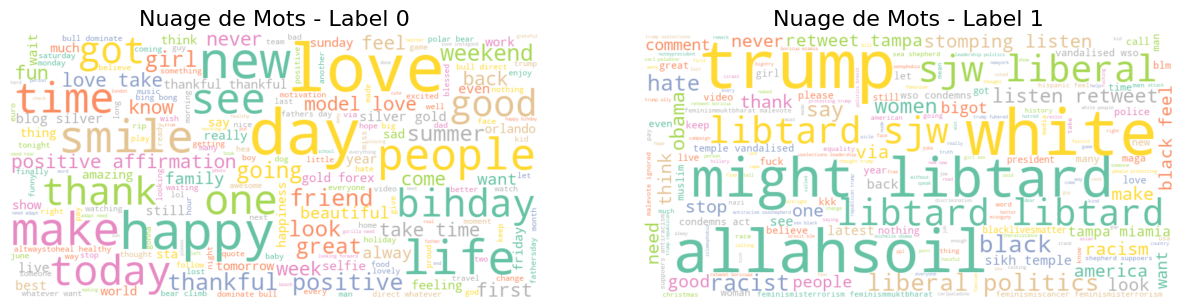

In [20]:
# Combine tweets processed by label 0 and label 1
tweets_label_0 = ' '.join(df[df['label'] == 0]['processed_tweet_str'])
tweets_label_1 = ' '.join(df[df['label'] == 1]['processed_tweet_str'])

# Configure the word cloud parameters
wordcloud_params = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'colormap': 'Set2',  # More vibrant color map
    'max_font_size': 100,  # Increase max font size for better visibility
    'random_state': 42  # For reproducibility
}

# Generate word clouds for both labels
wordcloud_label_0 = WordCloud(**wordcloud_params).generate(tweets_label_0)
wordcloud_label_1 = WordCloud(**wordcloud_params).generate(tweets_label_1)

# Plot the word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(wordcloud_label_0, interpolation='bilinear')
axes[0].axis('off')  # Hide axes
axes[0].set_title('Nuage de Mots - Label 0', fontsize=16)

axes[1].imshow(wordcloud_label_1, interpolation='bilinear')
axes[1].axis('off')  # Hide axes
axes[1].set_title('Nuage de Mots - Label 1', fontsize=16)

plt.show()


In [132]:
# Apply text substitutions
def clean_text(text):
    text = re.sub('like ', '', text)
    text = re.sub('new ', '', text)
    text = re.sub('people ', '', text)
    text = re.sub('bihday', 'birthday', text)
    text = re.sub('allahsoil', 'allah soil', text)
    text = re.sub('sjw', '', text)
    return text

# Apply the clean_text function to the 'tweet' column
df['processed_tweet_str'] = df['processed_tweet_str'].apply(clean_text)

# Display the cleaned DataFrame
print("Cleaned DataFrame:")
df.head()

df.to_csv('tweets_processed.csv', index=False)

Cleaned DataFrame:


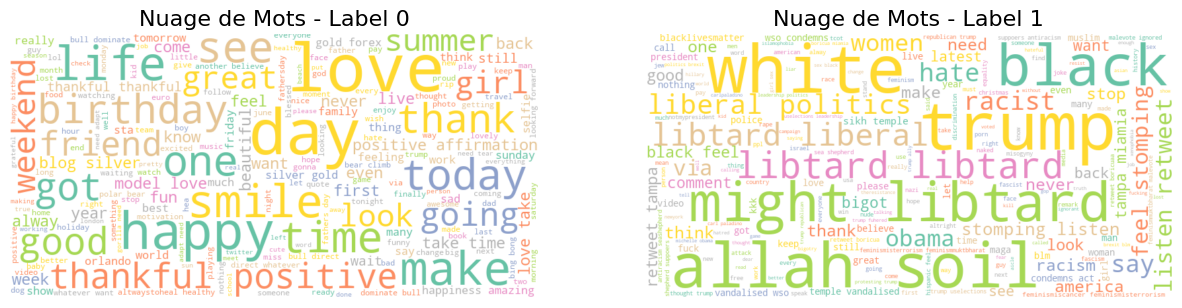

In [22]:
# Combine tweets processed by label 0 and label 1
tweets_label_0 = ' '.join(df[df['label'] == 0]['processed_tweet_str'])
tweets_label_1 = ' '.join(df[df['label'] == 1]['processed_tweet_str'])

# Configure the word cloud parameters
wordcloud_params = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'colormap': 'Set2',  # More vibrant color map
    'max_font_size': 100,  # Increase max font size for better visibility
    'random_state': 42  # For reproducibility
}

# Generate word clouds for both labels
wordcloud_label_0 = WordCloud(**wordcloud_params).generate(tweets_label_0)
wordcloud_label_1 = WordCloud(**wordcloud_params).generate(tweets_label_1)

# Plot the word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
axes[0].imshow(wordcloud_label_0, interpolation='bilinear')
axes[0].axis('off')  # Hide axes
axes[0].set_title('Nuage de Mots - Label 0', fontsize=16)

axes[1].imshow(wordcloud_label_1, interpolation='bilinear')
axes[1].axis('off')  # Hide axes
axes[1].set_title('Nuage de Mots - Label 1', fontsize=16)

plt.show()


#### Data Modeling

In [23]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_tweet_str'], df['label'], test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#### SVM classifier

In [24]:
# Initialize SVM classifier
svm_model = SVC(kernel='linear', random_state=42)

# Fit the model on the training data
svm_model.fit(X_train_tfidf, y_train)

# Make predictions on the test data
y_pred = svm_model.predict(X_test_tfidf)

# Evaluate the model
print("SVM Model Performance:")
print(classification_report(y_test, y_pred))


SVM Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5937
           1       0.86      0.45      0.59       456

    accuracy                           0.96      6393
   macro avg       0.91      0.72      0.79      6393
weighted avg       0.95      0.96      0.95      6393



#### Logistic Regression

In [46]:
# Logistic Regression Model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg_model.predict(X_test_tfidf)

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5937
           1       0.91      0.27      0.42       456

    accuracy                           0.95      6393
   macro avg       0.93      0.63      0.69      6393
weighted avg       0.94      0.95      0.93      6393



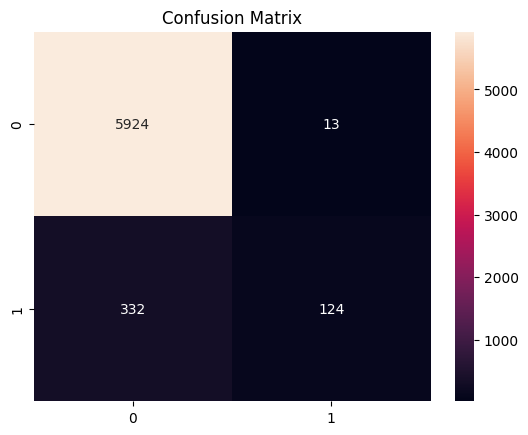

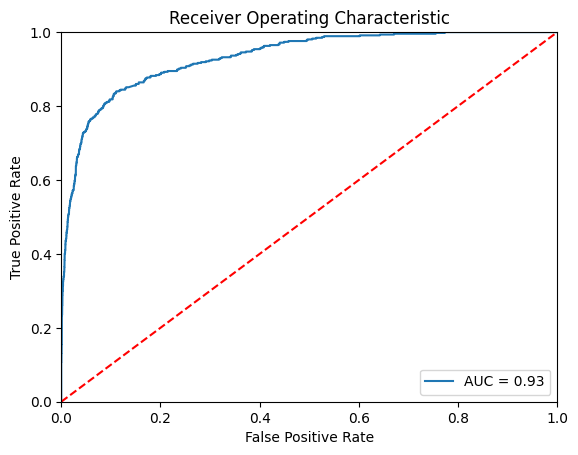

In [47]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve
y_pred_proba = logreg_model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### Naive Bayes

In [26]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("Naive Bayes Performance:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5937
           1       1.00      0.17      0.29       456

    accuracy                           0.94      6393
   macro avg       0.97      0.58      0.63      6393
weighted avg       0.94      0.94      0.92      6393



##### Accuracy vs f1 score

Accuracy is never a good metric for an imbalanced dataset as in this case. This can be highighted using the f1 score. A low f1-score for a label indicate poor performance of the model.

##### Weighted Logistic Regression Or Cost Sensitive Logistic Regression¶


In [27]:
df['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

In [28]:
# Values
count_0 = 29720
count_1 = 2242

# Calculate the ratio
ratio = count_0 / count_1

# Display the result
print(f"Class 0 is present approximately {ratio:.2f} times more than Class 1.")


Class 0 is present approximately 13.26 times more than Class 1.


In [42]:
# Define the weight of the class labels using inverse ratio
weights = {0: 1.0, 1: 13.00}

# Instantiate the logistic regression model and account for the weights to be applied for model coefficients update magnitude
logreg_model = LogisticRegression(solver='lbfgs', class_weight=weights, max_iter=1000, random_state=42)

# Fit the model
logreg_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_logreg = logreg_model.predict(X_test_tfidf)

# Classification report
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5937
           1       0.55      0.74      0.63       456

    accuracy                           0.94      6393
   macro avg       0.76      0.84      0.80      6393
weighted avg       0.95      0.94      0.94      6393



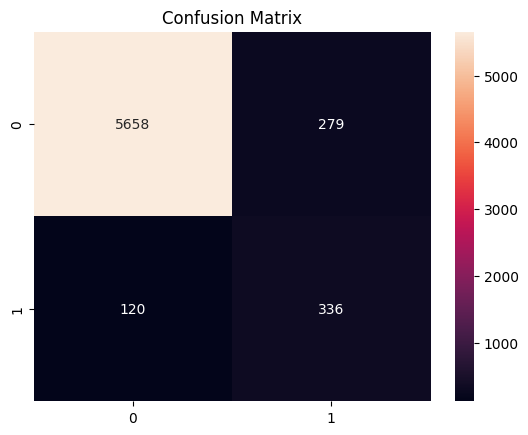

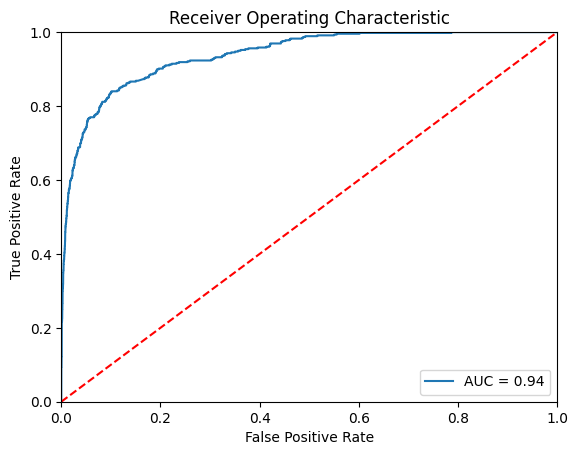

In [43]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve
y_pred_proba = logreg_model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### Regularization and Hyperparameter tuning

In [79]:
# define search space
from scipy.stats import loguniform
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

#check the search space 
print(space)

{'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'penalty': ['l1', 'l2', 'elasticnet'], 'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EA02A6F3A0>}


The solver, penalty, and C parameters are crucial for configuring a logistic regression model.

- The **solver** specifies the algorithm used for optimization, with options like 'newton-cg', 'lbfgs', and 'liblinear'.
- The **penalty** parameter defines the regularization type, including 'l1' (Lasso), 'l2' (Ridge), and 'elasticnet' (combination of both).
- The **C** parameter controls the inverse of regularization strength, with smaller values indicating stronger regularization.

Choosing these parameters wisely is essential for model performance and generalization.For instance, 'liblinear' is suitable for small datasets, while 'lbfgs' and 'newton-cg' handle larger datasets efficiently. Regularization helps prevent overfitting, with 'l2' being more common and 'l1' useful for feature selection. The C value should be tuned to balance bias and variance. By defining a search space with these parameters, you can systematically explore and optimize your model's performance.

#### Fine tuned Model with Balanced Class Weights

In [40]:
# Define balanced class weights
weights = {0: 1.0, 1: 1.0}

# Define the number of folds for cross-validation with shuffling enabled
folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Create an instance of RandomizedSearchCV with the model and search space
n_iter = 20  # Number of iterations for the random search
grid_search = RandomizedSearchCV(
    estimator=LogisticRegression(class_weight=weights, max_iter=1000, random_state=42),  # Use 'weights' here
    param_distributions=space,  # Assuming 'space' is defined elsewhere
    n_iter=n_iter,
    scoring='recall',
    n_jobs=-1,
    cv=folds,
    random_state=42
)

# Fit the grid search with tqdm to display the progress bar
# Use tqdm to perform the search iteratively
for _ in tqdm(range(n_iter), desc='Fitting Model'):
    grid_search.fit(X_train_tfidf, y_train)

# Predict using the best model found
y_pred_logreg = grid_search.predict(X_test_tfidf)

# Display the performance of the logistic regression model
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg))


Fitting Model: 100%|██████████| 20/20 [02:18<00:00,  6.94s/it]

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.79      0.55      0.65       456

    accuracy                           0.96      6393
   macro avg       0.88      0.77      0.81      6393
weighted avg       0.95      0.96      0.95      6393



#### Confusion Matrix & ROC-AUC Curve

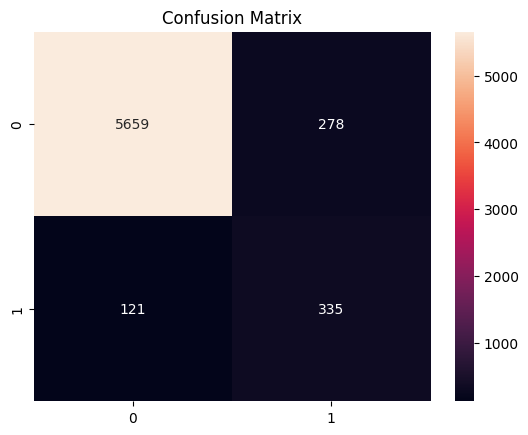

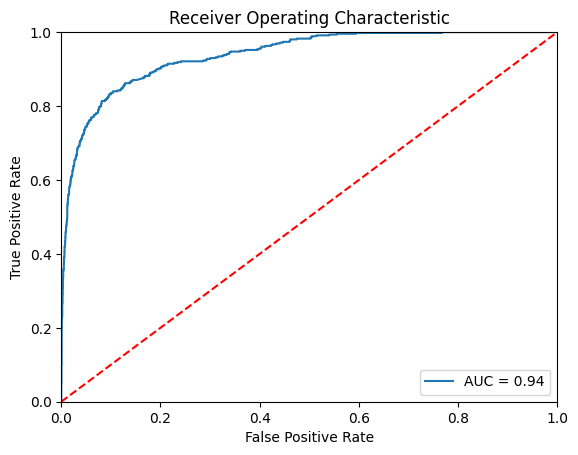

In [58]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve
y_pred_proba = logreg_model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


If the ROC curve doesn't reach the upper right corner (TPR = 1, FPR = 1), it indicates the model can't classify all positives correctly even with high false positives. This suggests model limitations or insufficient training data. The AUC remains useful for evaluating relative performance, even if the curve doesn't reach (1,1).

#### RandomForest

In [61]:
# Instantiate the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the number of trees to use in the Random Forest
n_estimators = 10  # You can adjust this number based on your needs

# Fit the model with a progress bar
for i in tqdm(range(n_estimators), desc='Training Random Forest'):
    rf_model.set_params(n_estimators=i+1)
    rf_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_tfidf)

# Classification report
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))


Training Random Forest: 100%|██████████| 10/10 [00:41<00:00,  4.18s/it]

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5937
           1       0.50      0.51      0.50       456

    accuracy                           0.93      6393
   macro avg       0.73      0.73      0.73      6393
weighted avg       0.93      0.93      0.93      6393



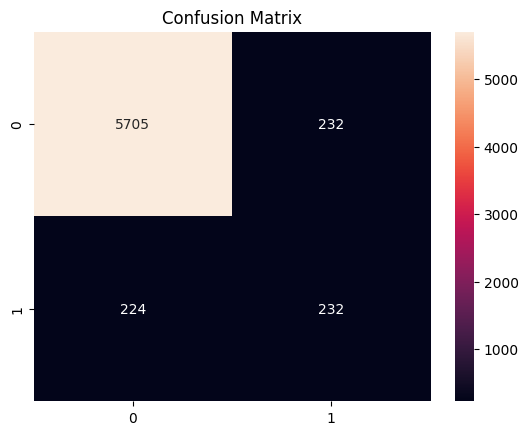

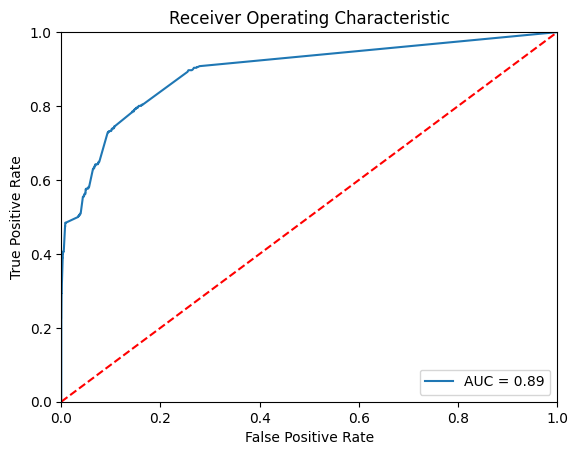

In [63]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Curve
y_pred_proba_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### Interpretation of the ROC Curve and AUC
ROC Curve: A ROC curve that approaches the upper left corner of the graph (where TPR = 1 and FPR = 0) indicates a good model. A ROC curve that follows the diagonal (dotted line) indicates a model that performs no better than random chance.

AUC: An AUC close to 1 indicates a highly performing model, while an AUC close to 0.5 indicates a model that performs no better than random chance.

#### Sentiment Analysis

In [34]:
# Function to analyze sentiment
def get_sentiment(tweet):
    analysis = TextBlob(tweet)
    # Scores range from -1 (negative) to +1 (positive)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis function to the processed tweets
df['sentiment'] = df['processed_tweet_str'].apply(get_sentiment)

# Display the DataFrame with sentiments
print(df[['tweet', 'sentiment']].head())


                                               tweet sentiment
0  [father, dysfunctional, selfish, drags, kids, ...  negative
1  [thanks, lyft, credit, use, cause, offer, whee...  positive
2                                  [bihday, majesty]   neutral
3                          [model, love, take, time]  positive
4                              [society, motivation]   neutral


In [35]:
# Compter les occurrences de chaque sentiment
comptes = df['sentiment'].value_counts()
print(comptes)


sentiment
positive    14095
neutral     13762
negative     4105
Name: count, dtype: int64


In [36]:
# Afficher un exemple de chaque tag dans la colonne 'sentiment'
exemples = df.groupby('sentiment').first().reset_index()
exemples


,sentiment,label,tweet,tweet_length,processed_tweet_str
0,negative,0,"[father, dysfunctional, selfish, drags, kids, ...",101,father dysfunctional selfish drags kids run
1,neutral,0,"[bihday, majesty]",19,birthday majesty
2,positive,0,"[thanks, lyft, credit, use, cause, offer, whee...",122,thanks lyft credit use cause offer wheelchair ...


#### Transformers

In [1]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


C:\Users\Catello\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the DataFrame from a CSV file
df_tweets_processed = pd.read_csv('tweets_processed.csv')

# Display the first few rows of the DataFrame
df_tweets_processed.head()

,label,tweet,tweet_length,processed_tweet_str
0,0,"['father', 'dysfunctional', 'selfish', 'drags'...",101,father dysfunctional selfish drags kids run
1,0,"['thanks', 'lyft', 'credit', 'use', 'cause', '...",122,thanks lyft credit use cause offer wheelchair ...
2,0,"['bihday', 'majesty']",19,birthday majesty
3,0,"['model', 'love', 'take', 'time']",86,model love take time
4,0,"['society', 'motivation']",38,society motivation


In [3]:
from transformers import pipeline

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
classifier = pipeline("sentiment-analysis", model=model_name)

In [6]:
# Apply sentiment analysis with a progress bar to the first 100 rows only
df_tweets_processed.loc[:99, 'sentiment'] = df_tweets_processed['tweet'].head(100).progress_apply(lambda x: classifier(x)[0]['label'])

# Display the DataFrame with sentiments for the first 100 rows
df_tweets_processed[['tweet', 'sentiment']].head(100)


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


,tweet,sentiment
0,"['father', 'dysfunctional', 'selfish', 'drags'...",NEGATIVE
1,"['thanks', 'lyft', 'credit', 'use', 'cause', '...",NEGATIVE
2,"['bihday', 'majesty']",POSITIVE
3,"['model', 'love', 'take', 'time']",POSITIVE
4,"['society', 'motivation']",POSITIVE
...,...,...
95,"['always', 'hope', 'one', 'day', 'get', 'hug',...",POSITIVE
96,"['model', 'love', 'take', 'time']",POSITIVE
97,"['couple', 'sex', 'fat', 'naked', 'japanese', ...",POSITIVE
98,"['hump', 'hump', 'day', 'humpers', 'pennsylvan...",NEGATIVE
